## Comparison of RoBERTa vs. ChatGPT

This notebook evaluates the performance of the fine-tuned RoBERTa model against OpenAI's **ChatGPT** (specifically, gpt-3.5-turbo) on a sampled subset of the Amazon reviews. It includes a series of visualizations and a summary of key metrics.

---

## Imports

In [ ]:
import os
import time
from typing import Dict, Any

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
)

from openai import OpenAI
from dotenv import load_dotenv


# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

## Final Sentiment Prediction and Export


In [ ]:
# Load the full dataset
df = pd.read_csv("../data/processed/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_cleaned.csv")
df['combined_review'] = df['title'] + " " + df['text']

# Load your fine-tuned model with all weights and configs
model_dir = r"C:\Users\nicol\Desktop\Ironhack\week6\Project_NLP\models\cardiffnlptwitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
config = AutoConfig.from_pretrained(model_dir)
model = AutoModelForSequenceClassification.from_pretrained(model_dir, config=config)

# Prepare for inference
predictions_roberta = []
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Batch processing for efficiency on the full dataset
batch_size = 32
for i in range(0, len(df), batch_size):
    batch = df['combined_review'].iloc[i:i + batch_size].tolist()
    
    # Ensure all reviews in the batch are strings
    batch = [str(review) if not pd.isna(review) else "" for review in batch]
    
    inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_ids = logits.argmax(dim=-1).cpu().numpy()
    
    predicted_labels = [model.config.id2label.get(id, str(id)) for id in predicted_class_ids]
    predictions_roberta.extend(predicted_labels)

df['predicted_sentiment_roberta'] = predictions_roberta
df['predicted_sentiment_roberta'] = df['predicted_sentiment_roberta'].str.lower()

# Save the updated DataFrame to a new CSV file
output_file_path = "../data/processed/Datafiniti_with_sentiments.csv"
df.to_csv(output_file_path, index=False)

                     id                                               name  \
0  AVqVGZNvQMlgsOJE6eUY  Amazon Kindle E-Reader 6" Wifi (8th Generation...   
1  AVqVGZNvQMlgsOJE6eUY  Amazon Kindle E-Reader 6" Wifi (8th Generation...   
2  AVqVGZNvQMlgsOJE6eUY  Amazon Kindle E-Reader 6" Wifi (8th Generation...   
3  AVqVGZNvQMlgsOJE6eUY  Amazon Kindle E-Reader 6" Wifi (8th Generation...   
4  AVqVGZNvQMlgsOJE6eUY  Amazon Kindle E-Reader 6" Wifi (8th Generation...   

        asins   brand                                         categories  \
0  B00ZV9PXP2  Amazon  Computers,Electronics Features,Tablets,Electro...   
1  B00ZV9PXP2  Amazon  Computers,Electronics Features,Tablets,Electro...   
2  B00ZV9PXP2  Amazon  Computers,Electronics Features,Tablets,Electro...   
3  B00ZV9PXP2  Amazon  Computers,Electronics Features,Tablets,Electro...   
4  B00ZV9PXP2  Amazon  Computers,Electronics Features,Tablets,Electro...   

                                                keys manufacturer  \
0  al

## Visualization & Scores

In [17]:
# Load environment variables
load_dotenv()

class SentimentAnalyzer:
    def __init__(self, df):
        self.df = df.copy()
        self.client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))
    
    def create_subset(self, n_per_class=20):
        subset_list = []
        for sentiment in ['positive', 'negative', 'neutral']:
            class_data = self.df[self.df['star_sentiment'].str.lower() == sentiment]
            if len(class_data) >= n_per_class:
                subset_list.append(class_data.sample(n=n_per_class, random_state=42))
        return pd.concat(subset_list, ignore_index=True)
    
    def get_chatgpt_prediction(self, text):
        try:
            response = self.client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[{
                    "role": "system", 
                    "content": "You are a sentiment classifier. Respond with EXACTLY one word: Positive, Negative, or Neutral. No other text."
                }, {
                    "role": "user", 
                    "content": f"Classify this sentiment: {text[:500]}"
                }],
                max_tokens=1,
                temperature=0
            )
            result = response.choices[0].message.content.strip()
            if result in ['Positive', 'Negative', 'Neutral']:
                return result
            else:
                return 'Neutral'
        except:
            return 'Neutral'
    
    def analyze_chatgpt_subset(self, subset_df):
        chatgpt_preds = []
        for i, row in subset_df.iterrows():
            text = str(row.get('combined_review', row.get('text', '')))
            pred = self.get_chatgpt_prediction(text)
            chatgpt_preds.append(pred)
            if len(chatgpt_preds) % 10 == 0:
                print(f"Processed {len(chatgpt_preds)}/{len(subset_df)}")
            time.sleep(0.5)
        
        subset_df = subset_df.copy()
        subset_df['chatgpt_prediction'] = chatgpt_preds
        return subset_df
    
    def plot_roberta_analysis(self):
        df_clean = self.df.dropna(subset=['star_sentiment', 'predicted_sentiment_roberta'])
        df_clean['star_sentiment'] = df_clean['star_sentiment'].str.lower()
        df_clean['predicted_sentiment_roberta'] = df_clean['predicted_sentiment_roberta'].str.lower()
        
        y_true = df_clean['star_sentiment']
        y_pred = df_clean['predicted_sentiment_roberta']
        labels = ['negative', 'neutral', 'positive']
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('RoBERTa vs True Labels Analysis', fontsize=14, fontweight='bold')
        
        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                   xticklabels=labels, yticklabels=labels, ax=axes[0,0])
        axes[0,0].set_title('Confusion Matrix')
        
        # Accuracy by class
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=labels)
        x = np.arange(len(labels))
        width = 0.25
        axes[0,1].bar(x - width, precision, width, label='Precision', alpha=0.8)
        axes[0,1].bar(x, recall, width, label='Recall', alpha=0.8)
        axes[0,1].bar(x + width, f1, width, label='F1-Score', alpha=0.8)
        axes[0,1].set_xticks(x)
        axes[0,1].set_xticklabels(labels)
        axes[0,1].legend()
        axes[0,1].set_title('Performance by Class')
        
        # Distribution comparison
        true_counts = y_true.value_counts()
        pred_counts = y_pred.value_counts()
        x = np.arange(len(labels))
        axes[1,0].bar(x - 0.2, [true_counts.get(l, 0) for l in labels], 0.4, label='True', alpha=0.8)
        axes[1,0].bar(x + 0.2, [pred_counts.get(l, 0) for l in labels], 0.4, label='Predicted', alpha=0.8)
        axes[1,0].set_xticks(x)
        axes[1,0].set_xticklabels(labels)
        axes[1,0].legend()
        axes[1,0].set_title('Distribution Comparison')
        
        # Overall accuracy
        accuracy = accuracy_score(y_true, y_pred)
        axes[1,1].bar(['RoBERTa'], [accuracy], color='green', alpha=0.7)
        axes[1,1].set_ylabel('Accuracy')
        axes[1,1].set_title(f'Overall Accuracy: {accuracy:.3f}')
        axes[1,1].set_ylim(0, 1)
        
        plt.tight_layout()
        plt.show()
        
        print(f"RoBERTa Accuracy: {accuracy:.3f}")
        print(classification_report(y_true, y_pred, target_names=labels))
        return accuracy
    
    def compare_models(self, subset_with_chatgpt):
        df_clean = subset_with_chatgpt.dropna()
        df_clean['star_sentiment'] = df_clean['star_sentiment'].str.lower()
        df_clean['predicted_sentiment_roberta'] = df_clean['predicted_sentiment_roberta'].str.lower()
        df_clean['chatgpt_prediction'] = df_clean['chatgpt_prediction'].str.lower()
        
        y_true = df_clean['star_sentiment']
        y_roberta = df_clean['predicted_sentiment_roberta']
        y_chatgpt = df_clean['chatgpt_prediction']
        
        roberta_acc = accuracy_score(y_true, y_roberta)
        chatgpt_acc = accuracy_score(y_true, y_chatgpt)
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Accuracy comparison
        models = ['ChatGPT', 'RoBERTa']
        accuracies = [chatgpt_acc, roberta_acc]
        axes[0].bar(models, accuracies, color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
        axes[0].set_ylabel('Accuracy')
        axes[0].set_title('Model Comparison')
        axes[0].set_ylim(0, 1)
        for i, v in enumerate(accuracies):
            axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center')
        
        # ChatGPT confusion matrix
        labels = ['positive', 'negative', 'neutral']
        cm_chatgpt = confusion_matrix(y_true, y_chatgpt, labels=labels)
        sns.heatmap(cm_chatgpt, annot=True, fmt='d', cmap='Reds',
                   xticklabels=labels, yticklabels=labels, ax=axes[1])
        axes[1].set_title('ChatGPT Confusion Matrix')
        
        # RoBERTa confusion matrix
        cm_roberta = confusion_matrix(y_true, y_roberta, labels=labels)
        sns.heatmap(cm_roberta, annot=True, fmt='d', cmap='Blues',
                   xticklabels=labels, yticklabels=labels, ax=axes[2])
        axes[2].set_title('RoBERTa Confusion Matrix')
        
        plt.tight_layout()
        plt.show()
        
        print(f"ChatGPT Accuracy: {chatgpt_acc:.3f}")
        print(f"RoBERTa Accuracy: {roberta_acc:.3f}")
        print(f"Agreement Rate: {(y_chatgpt == y_roberta).mean():.3f}")
        
        return chatgpt_acc, roberta_acc

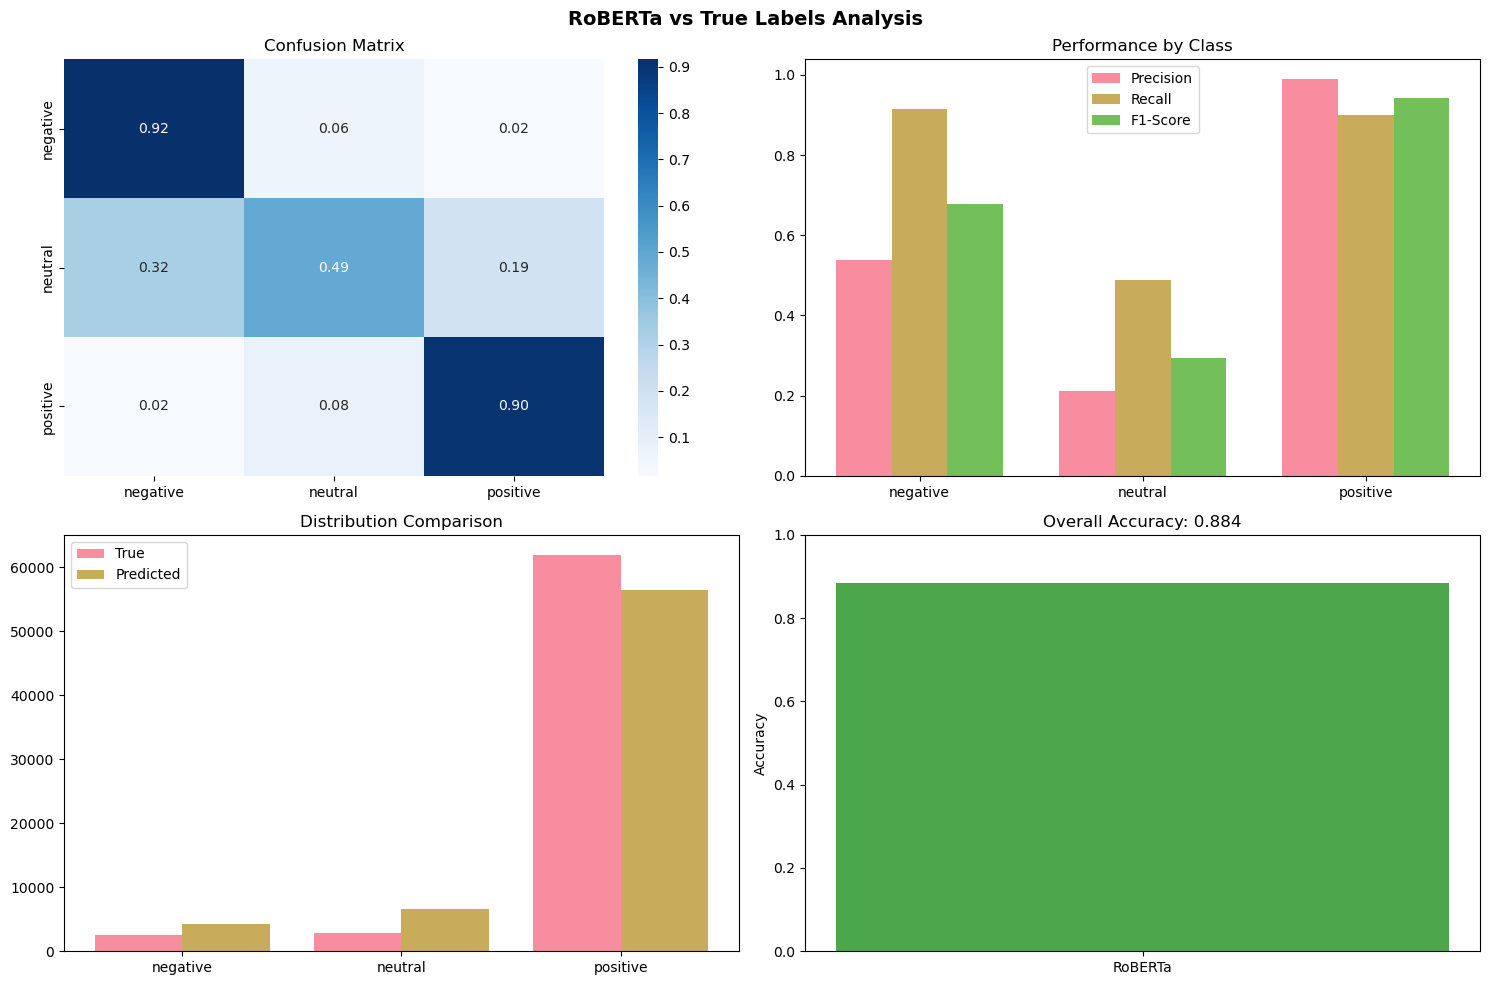

RoBERTa Accuracy: 0.884
              precision    recall  f1-score   support

    negative       0.54      0.92      0.68      2491
     neutral       0.21      0.49      0.29      2873
    positive       0.99      0.90      0.94     61953

    accuracy                           0.88     67317
   macro avg       0.58      0.77      0.64     67317
weighted avg       0.94      0.88      0.91     67317



In [18]:
df = pd.read_csv("../data/processed/Datafiniti_with_sentiments.csv")
analyzer = SentimentAnalyzer(df)

roberta_accuracy = analyzer.plot_roberta_analysis()

Processed 10/60
Processed 20/60
Processed 30/60
Processed 40/60
Processed 50/60
Processed 60/60


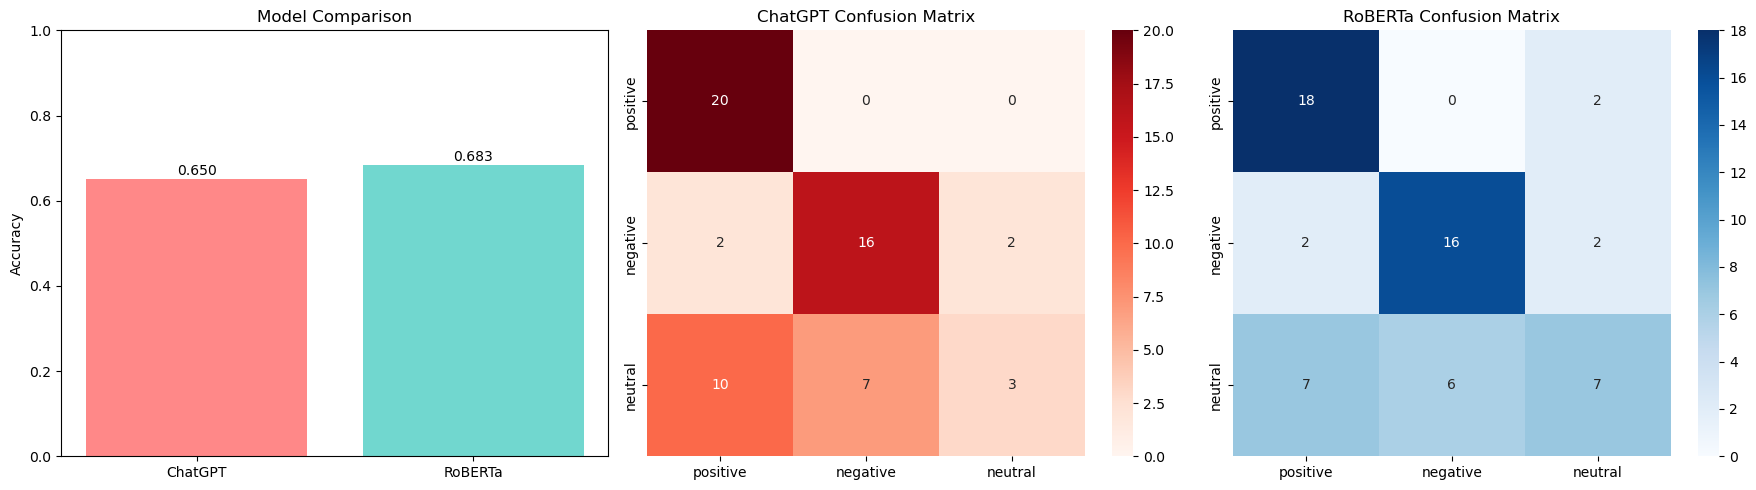

ChatGPT Accuracy: 0.650
RoBERTa Accuracy: 0.683
Agreement Rate: 0.867


In [4]:
subset = analyzer.create_subset(n_per_class=20)
subset_with_chatgpt = analyzer.analyze_chatgpt_subset(subset)
chatgpt_acc, roberta_acc = analyzer.compare_models(subset_with_chatgpt)